In this notebook, we will calculate key descriptive statistics for our main corpus after applying the pre-processing steps used for the LSTM model.

First, we load the articles from Handelsblatt, SZ, Welt, and dpa.

In [1]:
import os
import pandas as pd
from ast import literal_eval
from datetime import datetime
startTime = datetime.now()

# Set the path variable to point to the 'newspaper_data_processing' directory.
path = os.getcwd().replace('\\newspaper_analysis\\sentiment', '\\newspaper_data_processing')

# Load pre-processed 'dpa' dataset from a CSV file.
dpa = pd.read_csv(path + '\\dpa\\' + 'dpa_prepro_final.csv', encoding = 'utf-8', sep=';', index_col = 0,  keep_default_na=False,
                   dtype = {'rubrics': 'str', 
                            'source': 'str',
                            'keywords': 'str',
                            'title': 'str',
                            'city': 'str',
                            'genre': 'str',
                            'wordcount': 'str'},
                  converters = {'paragraphs': literal_eval})

dpa['source_statistics'] = 'dpa'

# Keep only the article texts and their respective publication dates.
dpa = dpa[['texts', 'day', 'month', 'year', 'source_statistics', 'date']]

# Load pre-processed 'SZ' dataset from a CSV file.
sz = pd.read_csv(path + '\\SZ\\' + 'sz_prepro_final.csv', encoding = 'utf-8-sig', sep=';', index_col = 0, dtype = {'newspaper': 'str',
                                                                                                 'newspaper_2': 'str',
                                                                                                 'quelle_texts': 'str',
                                                                                                 'page': 'str',
                                                                                                 'rubrics': 'str'})
sz.page = sz.page.fillna('')
sz.newspaper = sz.newspaper.fillna('')
sz.newspaper_2 = sz.newspaper_2.fillna('')
sz.rubrics = sz.rubrics.fillna('')
sz.quelle_texts = sz.quelle_texts.fillna('')

sz['source_statistics'] = 'sz'

# Keep only the article texts and their respective publication dates.
sz = sz[['texts', 'day', 'month', 'year', 'source_statistics', 'date']]

# Load pre-processed 'Handelsblatt' dataset from a CSV file.
hb = pd.read_csv(path + '\\Handelsblatt\\' + 'hb_prepro_final.csv', encoding = 'utf-8-sig', sep=';', index_col = 0, dtype = {'kicker': 'str',
                                                                                                 'page': 'str',
                                                                                                 'series_title': 'str',
                                                                                                 'rubrics': 'str'})
hb.page = hb.page.fillna('')
hb.series_title = hb.series_title.fillna('')
hb.kicker = hb.kicker.fillna('')
hb.rubrics = hb.rubrics.fillna('')

hb['source_statistics'] = 'hb'

hb['date'] = pd.to_datetime(hb[['year', 'month', 'day']])

# Keep only the article texts and their respective publication dates.
hb = hb[['texts', 'day', 'month', 'year', 'source_statistics', 'date']]

# Load pre-processed 'Welt' dataset from a CSV file.
welt = pd.read_csv(path + '\\Welt\\' + 'welt_prepro_final.csv', encoding = 'utf-8-sig', sep=';', index_col = 0, dtype = {'newspaper': 'str',
                                                                                                 'rubrics': 'str',
                                                                                                 'title': 'str'})
welt.title = welt.title.fillna('')
welt.rubrics = welt.rubrics.fillna('')

welt['source_statistics'] = 'welt'

welt['date'] = pd.to_datetime(welt[['year', 'month', 'day']])

# Keep only the article texts and their respective publication dates.
welt = welt[['texts', 'day', 'month', 'year', 'source_statistics', 'date']]

# Concatenate the 'dpa', 'sz', 'hb', and 'welt' DataFrames into a single DataFrame 'data'.
data = pd.concat([dpa, sz, hb, welt])

# The number of articles in the final dataset.
print(len(data))

# Sort the data in chronological order.
data = data.sort_values(['year', 'month', 'day'], ascending=[True, True, True])
# Reset the index of the DataFrame
data.reset_index(inplace=True, drop=True)
data.head()

3336299


,texts,day,month,year,source_statistics,date
0,Schalck: Milliardenkredit sicherte Zahlungsfäh...,1,1,1991,dpa,1991-01-01
1,Welajati: Iran bleibt bei einem Krieg am Golf ...,1,1,1991,dpa,1991-01-01
2,Bush will offenbar seinen Außenminister erneut...,1,1,1991,dpa,1991-01-01
3,Sperrfrist 1. Januar 1000 HBV fordert umfassen...,1,1,1991,dpa,1991-01-01
4,Schamir weist Nahost-Äußerungen des neuen EG-P...,1,1,1991,dpa,1991-01-01


Next, we import sentiment scores, previously computed using an LSTM model for each article in the corpus.

In [2]:
import csv

with open("scores_lstm.csv", "r", newline = "", encoding = "utf-8-sig") as f:
    reader = csv.reader(f)
    scores = [None if row[0] == '' else float(row[0]) for row in reader]

We add sentiment scores as a new column to the `data` DataFrame and discard any rows with missing sentiment scores.

In [3]:
# Add the sentiment scores as a new column in the data DataFrame
data['scores'] = scores

# Remove any rows in the DataFrame where a sentiment score is missing (NaN). In this context, 
# NaN corresponds to the model's inability to predict sentiment for certain 
# articles due to formatting issues or because the article is too short (less than 20 tokens).
data = data.dropna(subset=['scores'])

# Reset the index of the DataFrame
data.reset_index(inplace=True, drop=True)

In [4]:
# Count the total number of articles in the whole corpus
total_articles = len(data)

# Count the number of articles in each source separately
articles_per_source = data['source_statistics'].value_counts()

# Print out the results
print(f"Total number of articles in the corpus: {total_articles}\n")
print("Number of articles per source:")
print(articles_per_source)

Total number of articles in the corpus: 887300

Number of articles per source:
source_statistics
dpa     418549
hb      248320
sz      160963
welt     59468
Name: count, dtype: int64


# dpa

First, we will calculate the average number of articles published per day and per month to understand the publication frequency within our dataset.

In [5]:
dpa = data[data.source_statistics == 'dpa'].copy()

# Convert 'date' column to datetime
dpa['date'] = pd.to_datetime(dpa['date'])

# Calculate the average number of articles published per day
average_per_day_dpa = dpa.groupby(dpa['date'].dt.date)['texts'].count().mean()

# Calculate the average number of articles published per month
# This groups by year and month to get the total articles per month, then calculates the mean
average_per_month_dpa = dpa.groupby(['year', 'month'])['texts'].count().mean()

print("Average number of articles published per day:", average_per_day_dpa)
print("Average number of articles published per month:", average_per_month_dpa)

Average number of articles published per day: 40.925882467976926
Average number of articles published per month: 1245.6815476190477


Next, we will visualize the publishing frequency by plotting the number of articles published per day, incorporating a 30-day moving average to smooth out short-term fluctuations.

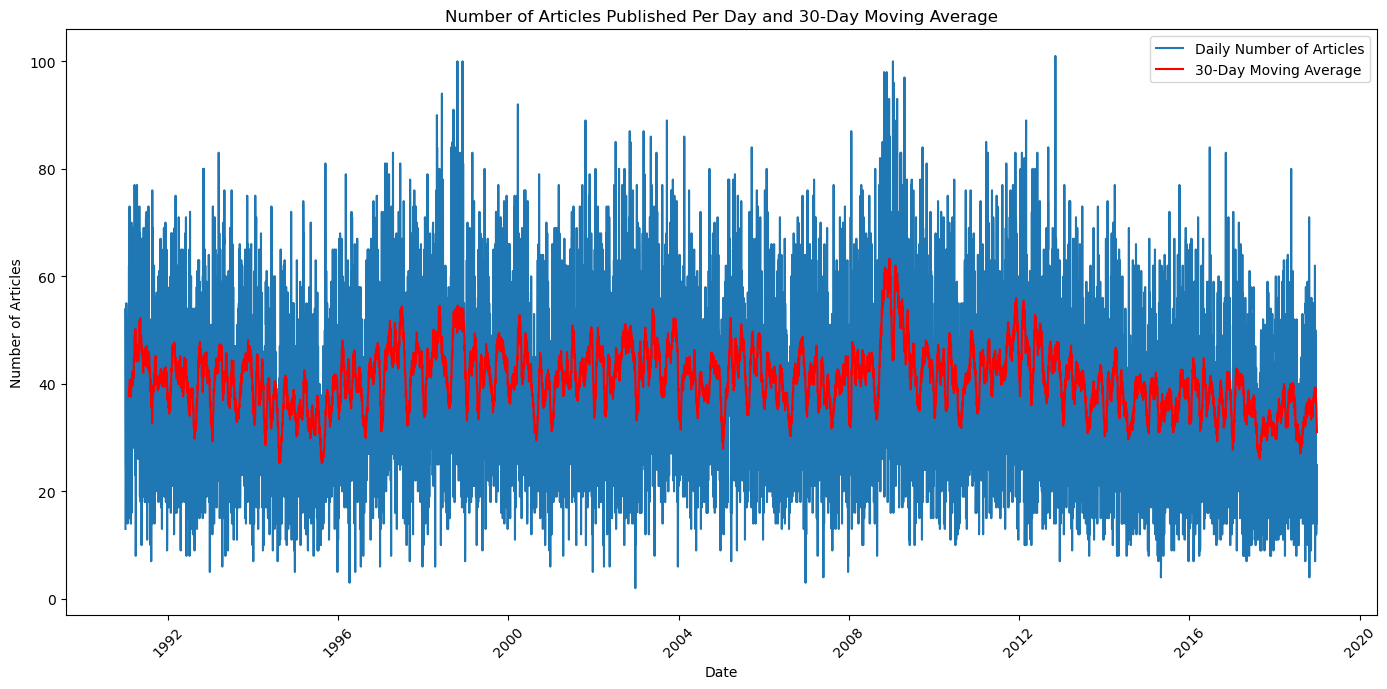

In [6]:
import matplotlib.pyplot as plt

# Aggregate data by date to count articles published each day
daily_count_dpa = dpa.groupby(dpa['date'].dt.date).size()

# Calculate the 30-day moving average
ma_dpa = daily_count_dpa.rolling(window=30).mean()

# Plotting
plt.figure(figsize=(14, 7))  # Set the figure size for better visibility
plt.plot(daily_count_dpa.index, daily_count_dpa, label='Daily Number of Articles')
plt.plot(ma_dpa.index, ma_dpa, label='30-Day Moving Average', color='red')

# Enhance the plot
plt.title('Number of Articles Published Per Day and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

# Show the plot
plt.show()

# SZ

In [7]:
sz = data[data.source_statistics == 'sz'].copy()

# Convert 'date' column to datetime
sz['date'] = pd.to_datetime(sz['date'])

# Calculate the average number of articles published per day
average_per_day_sz = sz.groupby(sz['date'].dt.date)['texts'].count().mean()

# Calculate the average number of articles published per month
# This groups by year and month to get the total articles per month, then calculates the mean
average_per_month_sz = sz.groupby(['year', 'month'])['texts'].count().mean()

print("Average number of articles published per day:", average_per_day_sz)
print("Average number of articles published per month:", average_per_month_sz)

Average number of articles published per day: 21.46459527937058
Average number of articles published per month: 538.3377926421405


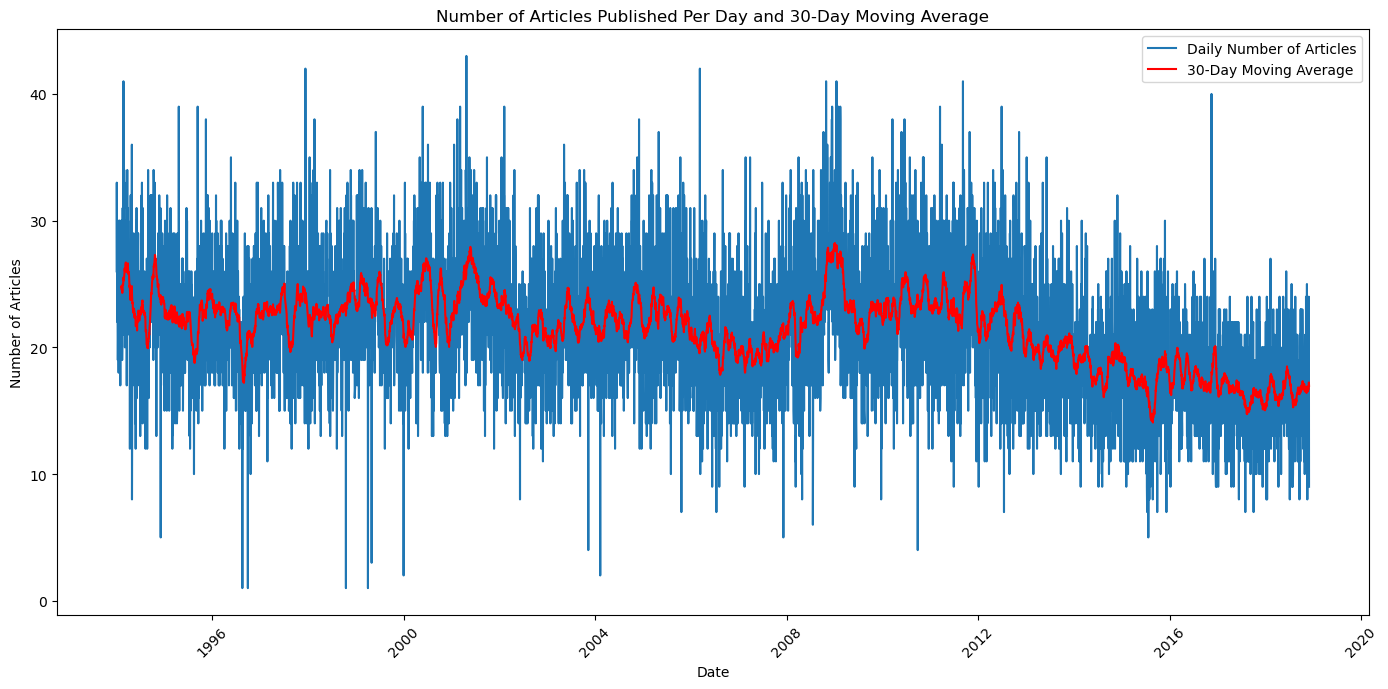

In [8]:
# Aggregate data by date to count articles published each day
daily_count_sz = sz.groupby(sz['date'].dt.date).size()

# Calculate the 30-day moving average
ma_sz = daily_count_sz.rolling(window=30).mean()

# Plotting
plt.figure(figsize=(14, 7))  # Set the figure size for better visibility
plt.plot(daily_count_sz.index, daily_count_sz, label='Daily Number of Articles')
plt.plot(ma_sz.index, ma_sz, label='30-Day Moving Average', color='red')

# Enhance the plot
plt.title('Number of Articles Published Per Day and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

# Show the plot
plt.show()

# Handelsblatt

In [9]:
hb = data[data.source_statistics == 'hb'].copy()

# Convert 'date' column to datetime
hb['date'] = pd.to_datetime(hb['date'])

# Calculate the average number of articles published per day
average_per_day_hb = hb.groupby(hb['date'].dt.date)['texts'].count().mean()

# Calculate the average number of articles published per month
# This groups by year and month to get the total articles per month, then calculates the mean
average_per_month_hb = hb.groupby(['year', 'month'])['texts'].count().mean()

print("Average number of articles published per day:", average_per_day_hb)
print("Average number of articles published per month:", average_per_month_hb)

Average number of articles published per day: 39.77574883869934
Average number of articles published per month: 830.5016722408027


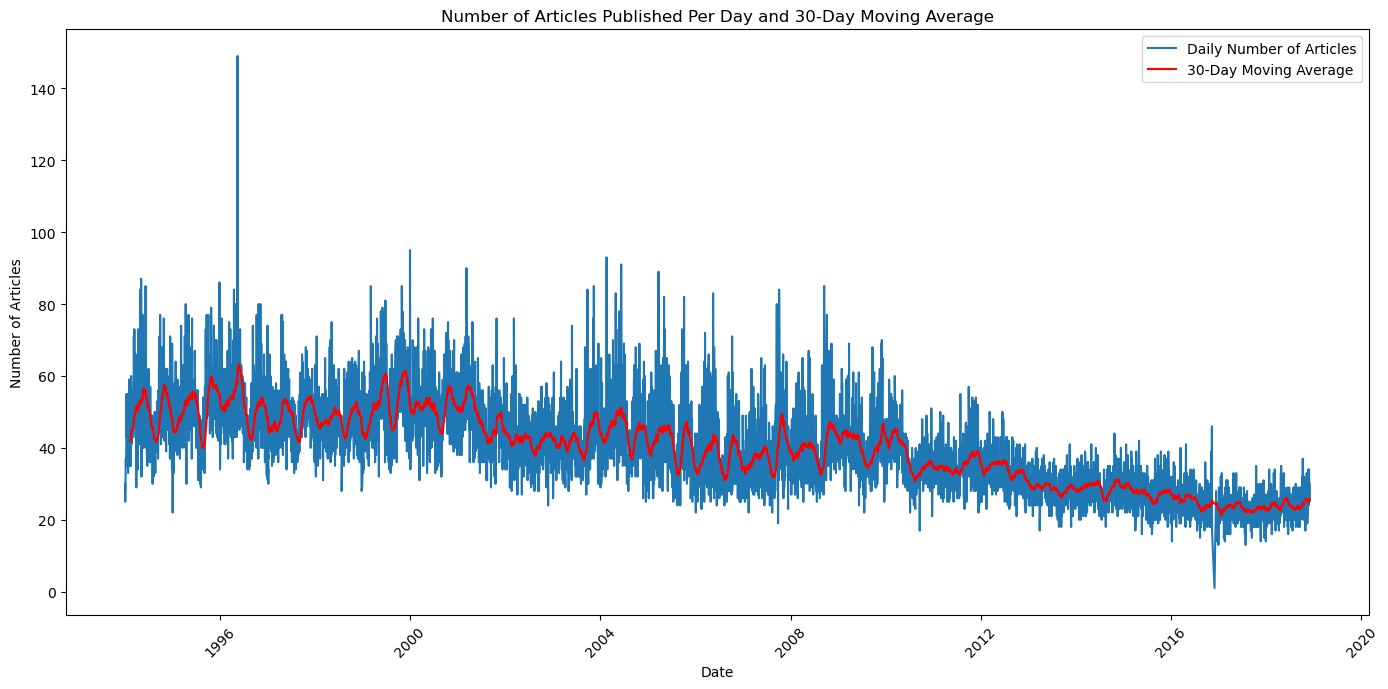

In [10]:
# Aggregate data by date to count articles published each day
daily_count_hb = hb.groupby(hb['date'].dt.date).size()

# Calculate the 30-day moving average
ma_hb = daily_count_hb.rolling(window=30).mean()

# Plotting
plt.figure(figsize=(14, 7))  # Set the figure size for better visibility
plt.plot(daily_count_hb.index, daily_count_hb, label='Daily Number of Articles')
plt.plot(ma_hb.index, ma_hb, label='30-Day Moving Average', color='red')

# Enhance the plot
plt.title('Number of Articles Published Per Day and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

# Show the plot
plt.show()

# Welt

We exclude periods from March 1999 to October 2000 and from January 2004 to April 2004 due to insufficient data availability in LexisNexis.

In [11]:
welt = data[data.source_statistics == 'welt'].copy()

# Convert 'date' column to datetime
welt['date'] = pd.to_datetime(welt['date'])

# Excluding specific time periods
exclusion_periods = [
    ('1999-03-01', '2000-10-31'),
    ('2004-01-01', '2004-04-30')
]

for start, end in exclusion_periods:
    start_date = pd.Timestamp(start)
    end_date = pd.Timestamp(end)
    welt = welt[~((welt['date'] >= start_date) & (welt['date'] <= end_date))]

# Calculate the average number of articles published per day
average_per_day_welt = welt.groupby(welt['date'].dt.date)['texts'].count().mean()

# Calculate the average number of articles published per month
# This groups by year and month to get the total articles per month, then calculates the mean
average_per_month_welt = welt.groupby(['year', 'month'])['texts'].count().mean()

print("Average number of articles published per day:", average_per_day_welt)
print("Average number of articles published per month:", average_per_month_welt)

Average number of articles published per day: 11.61484375
Average number of articles published per month: 292.9458128078818


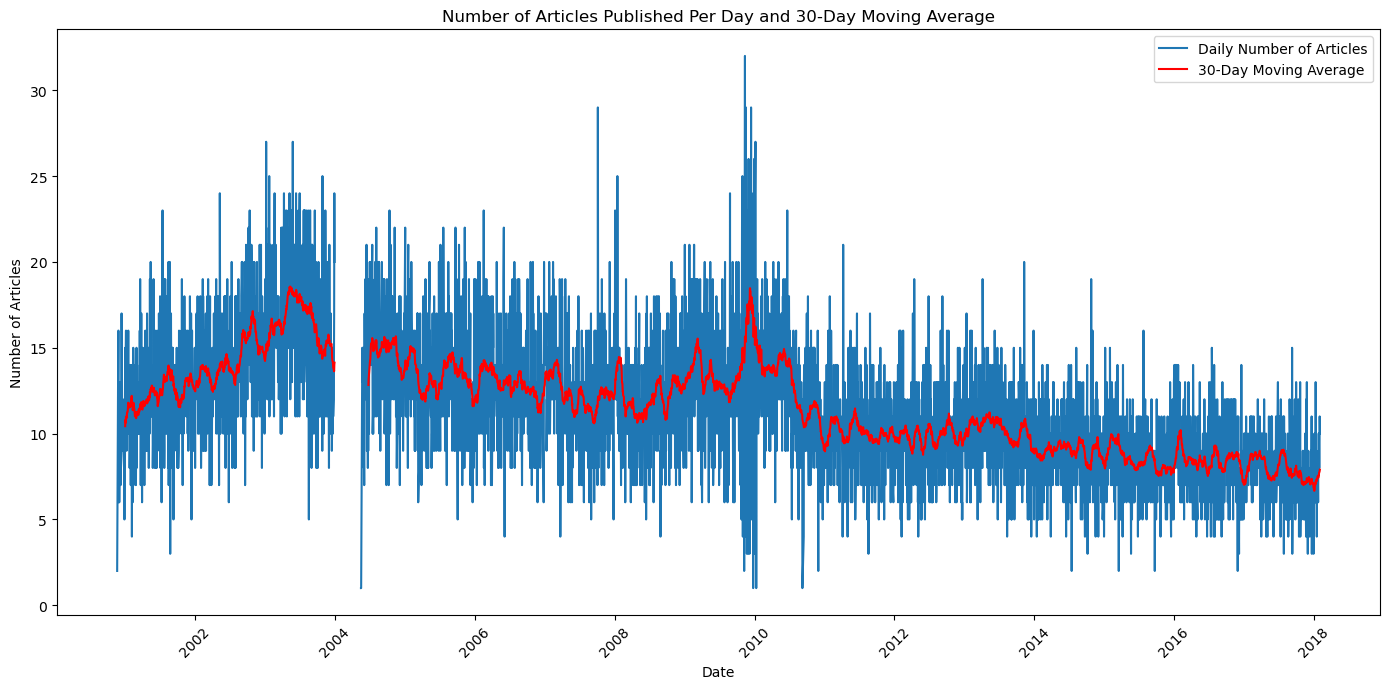

In [12]:
periods = [
    ('2000-11-20', '2003-12-31'),
    ('2004-05-01', '2018-01-31')
]

plt.figure(figsize=(14, 7))

# Get the first color from the current color cycle
default_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

for start, end in periods:
    # Filter the dataset for each period
    period_df = welt[(welt['date'] >= pd.Timestamp(start)) & (welt['date'] <= pd.Timestamp(end))]
    
    # Calculate the daily count and moving average for this period
    daily_count_period = period_df.groupby(period_df['date'].dt.date).size()
    ma_period = daily_count_period.rolling(window=30).mean()
    
    # Plot each period separately
    plt.plot(daily_count_period.index, daily_count_period, label='Daily Number of Articles', color = default_color)
    plt.plot(ma_period.index, ma_period, color='red', label='30-Day Moving Average')

# Enhance the plot
plt.title('Number of Articles Published Per Day and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()

# Adjust the legend. Since we're plotting the same labels for each period, let's clean this up.
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # This removes duplicate labels/handles
plt.legend(by_label.values(), by_label.keys())

# Show the plot
plt.show()

# Comparative Analysis of 30-Day Moving Averages Across Datasets

C:\Users\mokuneva\AppData\Local\Temp\2\ipykernel_9800\2035415082.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


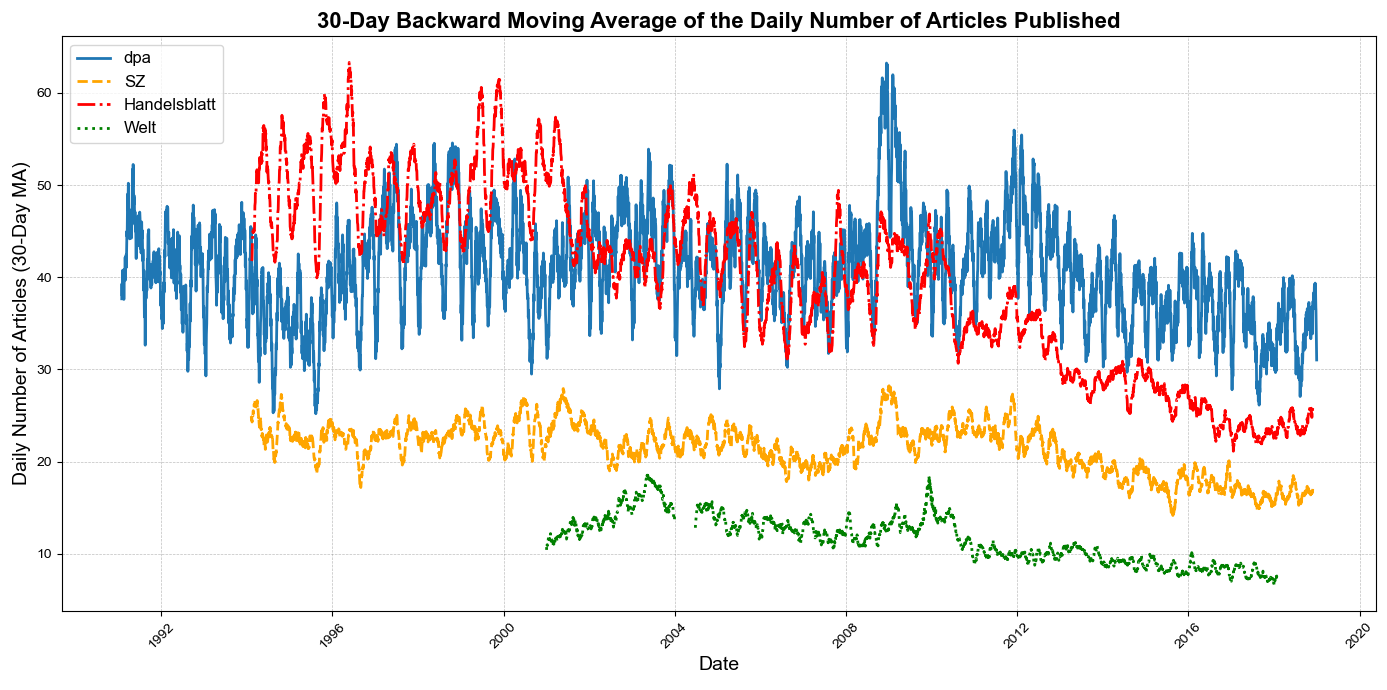

In [13]:
import matplotlib.pyplot as plt

# Set the figure size for better visibility
plt.figure(figsize=(14, 7))

# Plot the 30-day moving average for dpa, SZ, and Handelsblatt
plt.plot(ma_dpa.index, ma_dpa, label='dpa', linewidth=2)
plt.plot(ma_sz.index, ma_sz, label='SZ', linewidth=2, linestyle='dashed', color='orange')
plt.plot(ma_hb.index, ma_hb, label='Handelsblatt', linewidth=2, linestyle='dashdot', color='red')

# Plot each period for Welt separately to handle the gap
for start, end in periods:
    period_df = welt[(welt['date'] >= pd.Timestamp(start)) & (welt['date'] <= pd.Timestamp(end))]
    daily_count_period = period_df.groupby(period_df['date'].dt.date).size()
    ma_period = daily_count_period.rolling(window=30).mean()
    plt.plot(ma_period.index, ma_period, label='Welt' if start == periods[0][0] else "__nolegend__", color='green', linewidth=2, linestyle='dotted')

# Enhance the plot with a title, axis labels, and legend
plt.title('30-Day Backward Moving Average of the Daily Number of Articles Published', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Number of Articles (30-Day MA)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')

# Improve readability of the x-axis labels
plt.xticks(rotation=45)

# Set grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)

# Tighten the layout to make full use of space
plt.tight_layout()

# Apply a sophisticated look with a predefined style
plt.style.use('seaborn-darkgrid')

# Save the plot
plt.savefig('daily_publications_across_datasets_lstm_preprocessing.eps', format='eps')
plt.savefig('daily_publications_across_datasets_lstm_preprocessing.png', format='png')

# Show the plot
plt.show()

# Combined dataset

In [14]:
# Keep only the article texts and their respective publication dates.
dpa = dpa[['texts', 'day', 'month', 'year', 'date']]

# Add 'source' column with value 'dpa' for all rows
dpa['source'] = 'dpa'

# Keep only the article texts and their respective publication dates.
sz = sz[['texts', 'day', 'month', 'year', 'date']]

# Add 'source' column with value 'SZ' for all rows
sz['source'] = 'SZ'

# Keep only the article texts and their respective publication dates.
hb = hb[['texts', 'day', 'month', 'year', 'date']]

# Add 'source' column with value 'Handelsblatt' for all rows
hb['source'] = 'Handelsblatt'

# Keep only the article texts and their respective publication dates.
welt = welt[['texts', 'day', 'month', 'year', 'date']]

# Add 'source' column with value 'Welt' for all rows
welt['source'] = 'Welt'

# Concatenate the 'dpa', 'sz', 'hb', and 'welt' DataFrames into a single DataFrame 'data'.
data = pd.concat([dpa, sz, hb, welt])

# The number of articles in the final dataset.
print(len(data))

# Sort the data in chronological order.
data = data.sort_values(['year', 'month', 'day'], ascending=[True, True, True])
# Reset the index of the DataFrame
data.reset_index(inplace=True, drop=True)

887300


In [15]:
# Calculate the average number of articles published per day
average_per_day_combined = data.groupby(data['date'].dt.date)['texts'].count().mean()

# Calculate the average number of articles published per month
# This groups by year and month to get the total articles per month, then calculates the mean
average_per_month_combined = data.groupby(['year', 'month'])['texts'].count().mean()

print("Average number of articles published per day:", average_per_day_combined)
print("Average number of articles published per month:", average_per_month_combined)

Average number of articles published per day: 86.7605358365112
Average number of articles published per month: 2640.7738095238096
